# **Object detection using RetinaNet model on Vedai dataset**

In [1]:
!pip install keras_retinanet

import numpy as np
import shutil
import pandas as pd
import os, sys, random
import xml.etree.ElementTree as ET
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from PIL import Image
import requests
import urllib
from keras_retinanet.utils.visualization import draw_box, draw_caption , label_color , draw_boxes
from keras_retinanet.utils.image import preprocess_image, resize_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras_retinanet: filename=keras_retinanet-1.0.0-cp310-cp310-linux_x86_64.whl size=203716 sha256=ff2a1595883c6ab217707e072337fbf4e61fe4f462226386f4001300ff5ef966
  Stored in directory: /root/.cache/pip/wheels/42/ee/d4/b54905a92241002b36db880e88b902ebcb015ce5ae311a16da
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20457 sha256=fbb65aeb467208092b609efc6b4d0b4a4f41cde3298d50355a145fcac49d2404
  Stored in directory: /root/.cache/pip/wheels/16/af/88/a668b279c5eadbe55dcaf6207f09059135166cefb09088bacc
Successfully built keras_retinanet keras-resnet


# **cloning keras_retinanet and vedai dataset**

In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git
%cd /content/keras-retinanet

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6224, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6224 (delta 6), reused 9 (delta 2), pack-reused 6205
Receiving objects: 100% (6224/6224), 13.48 MiB | 26.81 MiB/s, done.
Resolving deltas: 100% (4206/4206), done.
/content/keras-retinanet


In [3]:
!git clone https://github.com/mr8bit/vedai.git

Cloning into 'vedai'...
remote: Enumerating objects: 8913, done.
remote: Total 8913 (delta 0), reused 0 (delta 0), pack-reused 8913
Receiving objects: 100% (8913/8913), 1.50 GiB | 38.74 MiB/s, done.
Resolving deltas: 100% (3671/3671), done.


**building proper dataset format as retinanet is expecting**

In [4]:
import os
import shutil

!mkdir /content/keras-retinanet/vedai/images/train-labels

sourcepath="/content/keras-retinanet/vedai/images/train"
sourcefiles = os.listdir(sourcepath)
destinationpath = "/content/keras-retinanet/vedai/images/train-labels"

for file in sourcefiles:
    if file.endswith('.xml'):
        shutil.move(os.path.join(sourcepath,file), os.path.join(destinationpath,file))

In [5]:
!python build_dataset.py \
    -l /content/keras-retinanet/vedai/images/train-labels/ \
    -i /content/keras-retinanet/vedai/images/train/ \
    -r /content/keras-retinanet/vedai/images/train/train.csv \
    -e /content/keras-retinanet/vedai/images/train/test.csv \
    -c /content/keras-retinanet/vedai/images/train/classes.csv

[INFO] creating 'train' set ...
[INFO] 1599 total images in 'train'
[INFO] writing train annotations ...
[INFO] total 5149 annotations
[INFO] train.csv completed
[INFO] creating 'test' set ...
[INFO] 400 total images in 'test'
[INFO] writing test annotations ...
[INFO] total 1311 annotations
[INFO] test.csv completed
[INFO] writing classes ...
[INFO] classes.csv completed
[FINAL] Task completed!


**defining functions for showing bounding box around vehicles in the imeges**

In [6]:
def custom_plot(data : pd.core.frame.DataFrame , sample_list : list , subset_dir : str ):

  plt.figure(figsize=(15, 15))

  for idx , im_name in enumerate(sample_list):

    df = data[data[data.columns[0]] == im_name]
    dfcols = df.columns
    df = df[[dfcols[1] , dfcols[2] , dfcols[3] , dfcols[4] ]]
    boxes_list = df.values.tolist()

    plt.subplot(330 + idx + 1)

    im = np.array(Image.open(subset_dir + im_name))

    draw_boxes(im , boxes_list , color=(255 , 0 , 0))

    plt.axis('off')
    plt.imshow(im)

  plt.show()

def get_boxes_list(data : pd.core.frame.DataFrame , im_name : str ):

    df = data[data[data.columns[0]] == im_name]
    dfcols = df.columns
    df = df[[dfcols[1] , dfcols[2] , dfcols[3] , dfcols[4] ]]
    boxes_list = df.values.tolist()
    return boxes_list


def custom_plot2(data1 : pd.core.frame.DataFrame , data2 : pd.core.frame.DataFrame ,
                   sample_list : list , subset_dir : str ):

  for idx , im_name in enumerate(sample_list):

    plt.figure(figsize=(10, 10))
    boxes_list1 = get_boxes_list(data1 , im_name)

    plt.subplot(121)

    im1 = np.array(Image.open(subset_dir + im_name))

    draw_boxes(im1 , boxes_list1 , color=(0 , 255 , 0))
    plt.axis('off')
    plt.imshow(im1)

    boxes_list2 = get_boxes_list(data2 , im_name)
    plt.subplot(122)

    im2 = np.array(Image.open(subset_dir + im_name))

    draw_boxes(im2 , boxes_list2 , color=(255, 0 , 0))
    plt.axis('off')
    plt.imshow(im2)
    plt.show()

def custom_plot3(data : pd.core.frame.DataFrame ,sample_list : list , subset_dir : str ):

  plt.figure(figsize=(15, 15))

  for idx , im_name in enumerate(sample_list):

    plt.subplot(330 + idx + 1)

    im = np.array(Image.open(subset_dir + im_name))

    df = data[data[data.columns[0]] == im_name ]

    for i , box in df.iterrows():

        box_list = box.tolist()[1:5]
        pred_type = box.tolist()[6]

        if(pred_type == 'TP'):
            draw_box(im , box_list , color=(0 , 128 , 0))

        elif(pred_type == 'FN'):
         draw_box(im , box_list , color=(255 , 0 , 0))

        elif(pred_type == 'FP'):
         draw_box(im , box_list , color=(255 , 255 , 0))

    plt.axis('off')
    plt.imshow(im)

  plt.show()

**showing some of the input images and their labels (bounding boxes)**

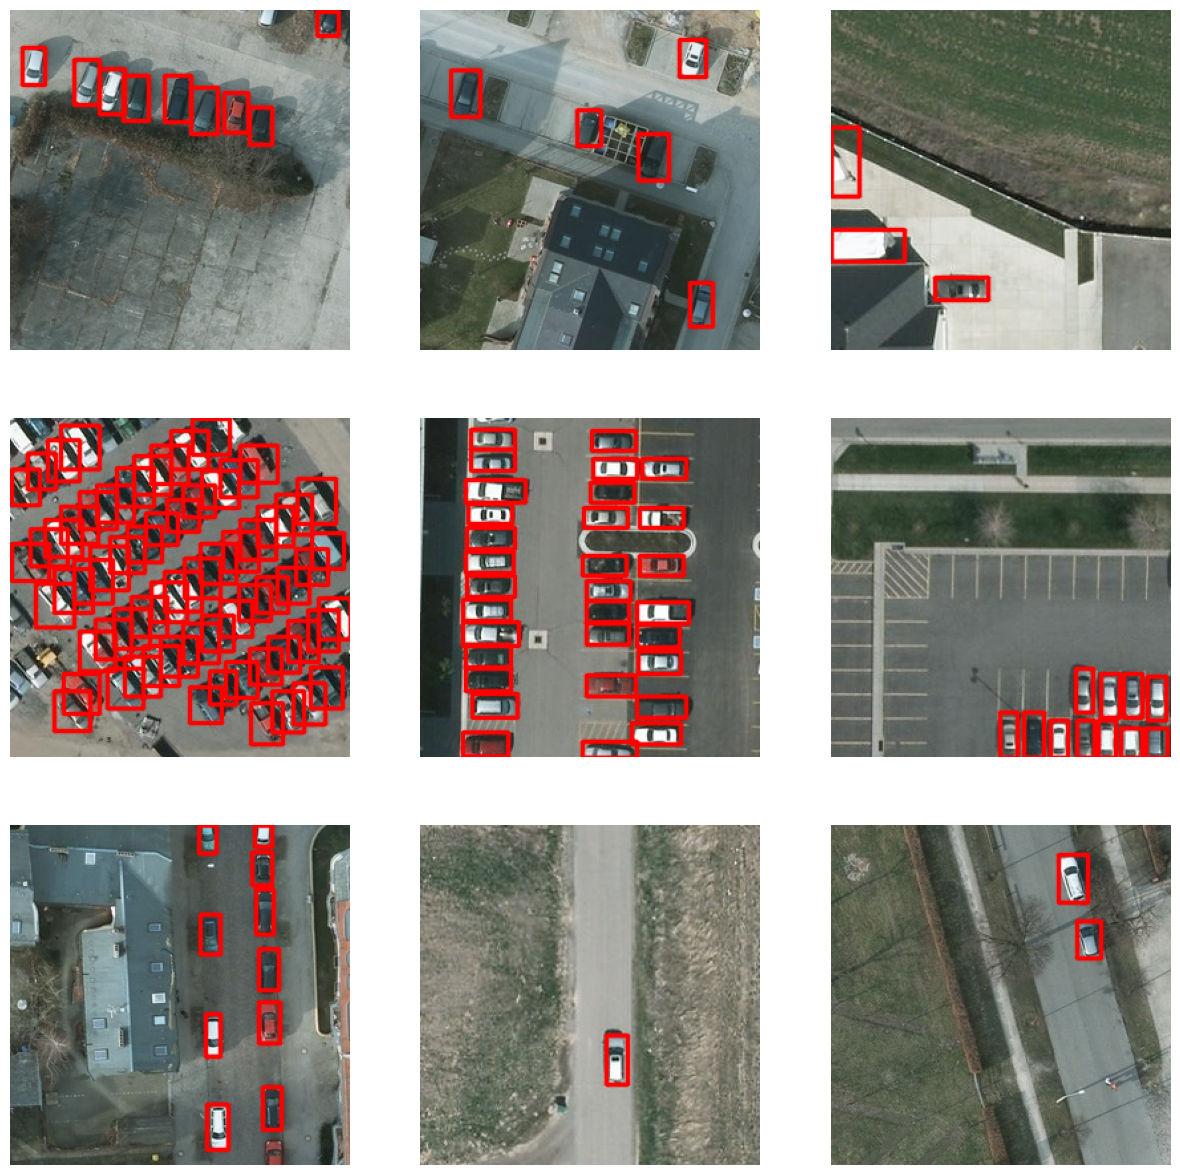

In [7]:
data = pd.read_csv('/content/keras-retinanet/vedai/images/train/train.csv')
sample_data = data.sample(n=9)
sample_list = sample_data[sample_data.columns[0]].tolist()
custom_plot(data , sample_list , "/content/keras-retinanet/vedai/images/train/")

# **start training our model on vedai dataset**

In [8]:
!python setup.py build_ext --inplace

/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running build_ext
Compiling keras_retinanet/utils/compute_overlap.pyx because it changed.
[1/1] Cythonizing keras_retinanet/utils/compute_overlap.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_r

In [16]:
import urllib.request

PRETRAINED_MODEL = '/content/keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'

urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

('/content/keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5',
 <http.client.HTTPMessage at 0x7a44875609a0>)

In [10]:
!python /content/keras-retinanet/keras_retinanet/bin/train.py \
--freeze-backbone \
--random-transform \
--weights {PRETRAINED_MODEL} \
--weighted-average \
--batch-size 3 \
--steps 31 \
--epochs 20 \
csv '/content/keras-retinanet/vedai/images/train/train.csv' '/content/keras-retinanet/vedai/images/train/classes.csv'

2023-10-15 21:28:29.629600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 21:28:31.043864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Creating model, this may take a second...
2023-10-15 21:28:32.982529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 21:28:33.528969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be a

# **evaluate trainde model**
**convret model got from last epoch to inference model**

In [41]:
!python /content/keras-retinanet/keras_retinanet/bin/convert_model.py \
 '/content/keras-retinanet/snapshots/resnet50_csv_20.h5' \
 '/content/keras-retinanet/vedai_models/resnet50_csv_20.h5'

2023-10-15 22:57:29.654958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 22:57:30.582434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-15 22:57:32.184228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 22:57:32.215829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [42]:
inference_model = '/content/keras-retinanet/vedai_models/resnet50_csv_20.h5'

In [43]:
!python /content/keras-retinanet/keras_retinanet/bin/evaluate.py \
csv '/content/keras-retinanet/vedai/images/train/test.csv' \
'/content/keras-retinanet/vedai/images/train/classes.csv' \
{inference_model}

2023-10-15 22:58:29.539743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 22:58:30.500176: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading model, this may take a second...
2023-10-15 22:58:32.398964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 22:58:32.429007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at

**run predict_boxes.py file to save our model predictions in a csv file for test imeges**

In [44]:
!python /content/keras-retinanet/predict_boxes.py \
-i /content/keras-retinanet/vedai/images/train/  \
-t 0.6 \
-m {inference_model} \
-o /content/keras-retinanet/vedai/images/ \
-l /content/keras-retinanet/vedai/images/train/classes.csv \
-c /content/keras-retinanet/vedai/images/train/test.csv

2023-10-15 22:59:28.901782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 22:59:29.888026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-15 22:59:31.413918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-15 22:59:31.447579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

### **let's analayze  deeply and get TP , FN , FP and f1 score of our trained model**

**for this first we define some metrics functions**

In [47]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def IOU(box1, box2):
  x1 , y1 , x2 , y2 = box1
  x3 , y3 , x4 , y4 = box2
  intersect_w = _interval_overlap([x1 , x2] , [x3 , x4])
  intersect_h = _interval_overlap([y1 , y2] , [y3 , y4])
  intersect = intersect_w * intersect_h
  w1, h1 = x2 - x1 , y2 - y1
  w2, h2 = x4 - x3 , y4 -y3
  union = w1*h1 + w2*h2 - intersect
  return float(intersect) / union

def get_pred_type(L_data : pd.core.frame.DataFrame , R_data : pd.core.frame.DataFrame ,
                  thresh : float = 0.6 , left_is_pred : bool = True ):

  L_data = L_data.assign(pred_type = 'NAN')

  for idx , row in L_data.iterrows():

    row_list = row.tolist()
    df = R_data[R_data[R_data.columns[0]] == row_list[0] ]
    iou_list = []

    for i , right_row in df.iterrows():

      iou_list.append(IOU(row_list[1:5] , right_row.tolist()[1 : 5 ])  )

    if left_is_pred == True :
      if len(iou_list) > 0 and max(iou_list) >= thresh:
        L_data.at[idx , 'pred_type'] = 'TP'

      else:
        L_data.at[idx , 'pred_type'] = 'FP'

    else:

     if len(iou_list) > 0 and max(iou_list) >= thresh:
       L_data.at[idx , 'pred_type'] = 'TP'

     else:
       L_data.at[idx , 'pred_type'] = 'FN'
  return L_data

def get_f1_score(TP , FP , FN):
    Precision_Score = TP / (FP + TP)
    Recall_Score    = TP / (FN + TP)
    F1_Score = (2 * Precision_Score * Recall_Score) / (Precision_Score + Recall_Score)
    return Precision_Score , Recall_Score , F1_Score

In [48]:
data1 = get_pred_type(data1 , data2 , thresh=0.5 , left_is_pred=False)
data2 = get_pred_type(data2 , data1 , thresh = 0.5)

In [49]:
sdf = data1[data1['pred_type'] == 'TP'].copy()

sdf = sdf.append(data1[data1['pred_type'] == 'FN'].copy() , ignore_index=True)

df = data2.drop(data2.columns[6], axis=1)
df.columns = sdf.columns
sdf = sdf.append(df[df['pred_type'] == 'FP'].copy() , ignore_index=True)

sdf

<ipython-input-49-c0255a72cfcd>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sdf = sdf.append(data1[data1['pred_type'] == 'FN'].copy() , ignore_index=True)
<ipython-input-49-c0255a72cfcd>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sdf = sdf.append(df[df['pred_type'] == 'FP'].copy() , ignore_index=True)


,15861.jpg,104,3,144,19,car,pred_type
0,20761.jpg,56,13,75,47,car,TP
1,19918.jpg,6,132,49,152,car,TP
2,6576.jpg,89,108,105,147,car,TP
3,6576.jpg,140,95,161,137,pickup,TP
4,357.jpg,0,83,17,116,car,TP
...,...,...,...,...,...,...,...
1410,20389.jpg,142,153,169,187,car,FP
1411,579.jpg,49,4,85,31,car,FP
1412,63.jpg,98,24,136,59,car,FP
1413,20944.jpg,113,196,140,229,car,FP


### **our model prediction on test dataset**
(TP : green , FP : yellow , FN : red)

outputs of trained model : (TP : green , FP : yellow , FN : red)


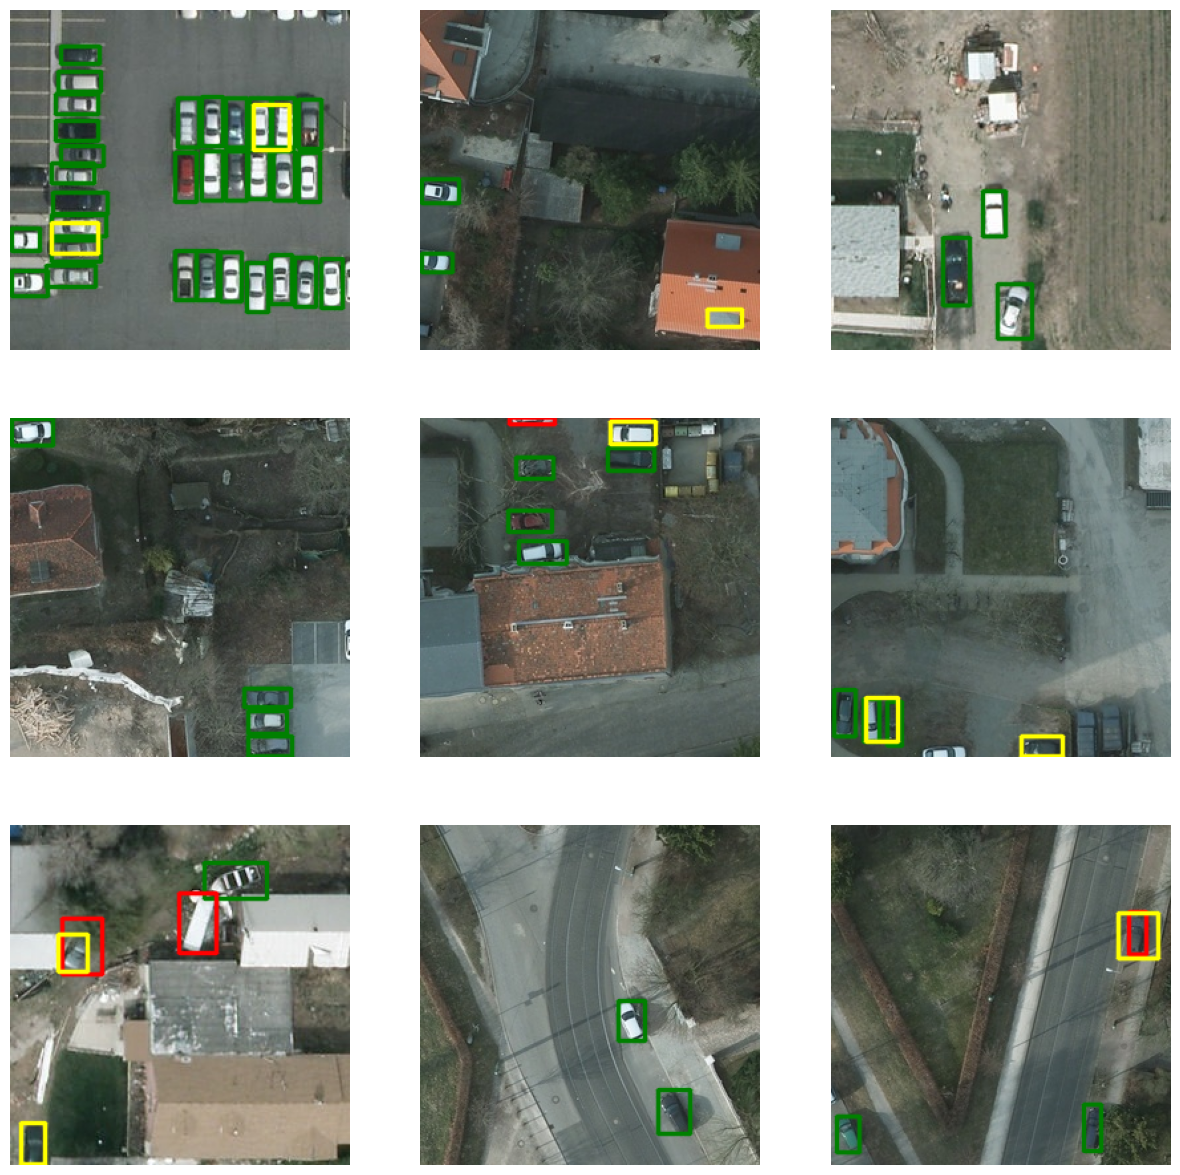

In [50]:
print('outputs of trained model : (TP : green , FP : yellow , FN : red)')
custom_plot3(sdf , sample_list , "/content/keras-retinanet/vedai/images/train/")

**finally let's get perecision , recall and f1_score of trained model**

In [51]:
TP = sdf['pred_type'].value_counts()['TP']
FP = sdf['pred_type'].value_counts()['FP']
FN = sdf['pred_type'].value_counts()['FN']
print('precesion , recall and f1_score of model')
print(get_f1_score(TP , FP , FN))

precesion , recall and f1_score of model
(0.9099485420240138, 0.8099236641221375, 0.8570274636510501)
